# 猫狗大战

这个项目使用 python3.5 + tensorflow 1.0 + gpu环境

In [1]:
# 导入库
import tensorflow as tf
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import time
import sys, traceback

import warnings
warnings.filterwarnings('ignore')

import TFHelper
import CatDogDataset

%matplotlib inline

In [2]:
# 全局变量
IMG_SZ = 256
IMG_FT = IMG_SZ * IMG_SZ * 3
LABTXT = ['Cat', 'Dog', 'NODATA']


# 图像可视化
def visualize(imgs, real=None, pred=None):
    if pred is not None:
        pred = pred.reshape(-1)
        predclass = np.piecewise(pred, [pred < 0.5, pred >= 0.5], [0, 1])
        
    size = min(len(imgs), 25)
    fig = plt.figure(figsize=(20, 20))
    if imgs.shape[3] == 1:
        imgs = imgs[:, :, :, -1]
    for i in range(0, size):
        fig.add_subplot(1, size, i + 1) 
        plt.imshow(imgs[i] + .5)  # display it
        predtxt = ""
        if pred is not None:
            plt.xlabel('probability: {}({:.2%})'.format( LABTXT[int(predclass[i])], abs(pred[i] - 0.5) * 2))
        else:
            plt.xlabel('real: ' + (real is not None and LABTXT[int(real[i])]))

# 二元精确度
def accuracy(predictions, labels):
    assert(predictions.shape == labels.shape)
    assert(predictions.dtype == labels.dtype)
    pred = np.piecewise(predictions, [predictions < 0.5, predictions >= 0.5], [0, 1])
#     print(pred)
#     print(labels)
#     print(pred == labels, np.sum(pred == labels))
    return 'accuracy', np.sum(pred == labels) / len(labels) * 100

#批次计算精确率
def batch_mean(generator, step, func):
    accs = []
    for i in range(step):
        x,y = next(generator)
        accs.append( func(x, y) )
    print(accs)
    return np.mean(accs)
    
# 图像可视化预测结果
def visualize_predict(clf, generator):   
    x,y = next(generator)
    predict_lab = clf.predict(x)
    visualize(x, y, predict_lab)

skip: train/dog.10237.jpg
skip: train/
skip: test/
train datas:  20000


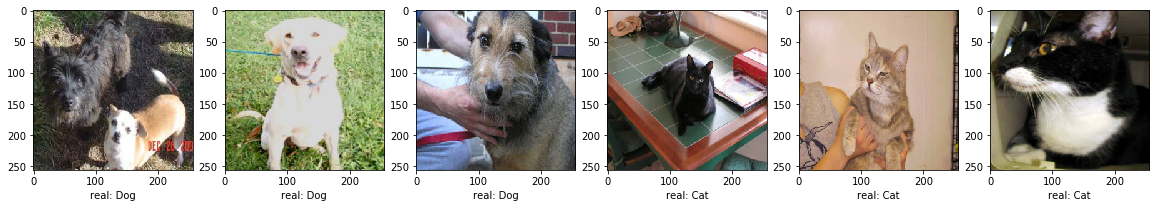

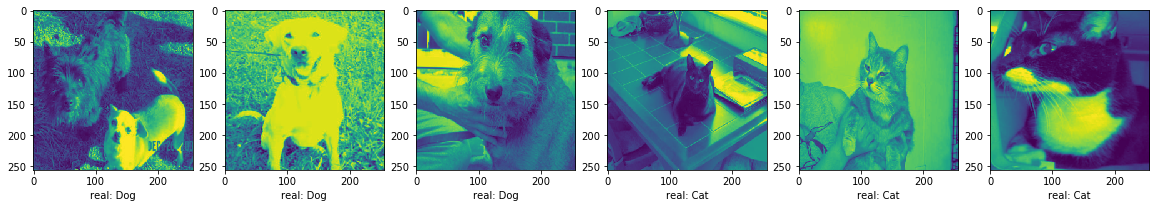

In [3]:
# 数据集准备
CatDogDataset = reload(CatDogDataset)

train, vali, test = CatDogDataset.get_kaggle_reader()
print('train datas: ', train.count)

# 列出数据集里的图 
train_reader = train.get_generator(batch_size=6, image_size=IMG_SZ)
visualize(*next(train_reader))
train_reader = None #clean memory

# 灰度
train_gray_reader = train.get_generator(batch_size=6, image_size=IMG_SZ, gray=True)
visualize(*next(train_gray_reader))
train_gray_reader = None #clean memory

# 检测数据集平衡性

In [4]:
train_labels = train.labels
print(np.sum(train_labels), len(train_labels), 'dog/all:', np.sum(train_labels) / len(train_labels))

10002.0 20000 dog/all: 0.5001


# 使用线性分类 (可跳过执行）

In [4]:
train_reader = train.get_generator(batch_size=128, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=128, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=500, image_size=IMG_SZ)
total_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)
vali_dat = vali_dat.reshape(-1, IMG_FT)

from sklearn.linear_model import SGDClassifier
linear_clf = SGDClassifier(penalty='elasticnet', loss='log')

start = time.time()
try:
    for batch in range(0, total_steps):
        dat, lab = next(train_reader)
        dat = dat.reshape(-1, IMG_FT)
        linear_clf.partial_fit(dat, lab, [0,1])
        TFHelper.step_info(batch + 1, total_steps, 
                  {'accuracy': str(round(linear_clf.score(vali_dat, vali_lab)*100, 2)) + '%' })
    print('\nend ', str(time.time() - start), 's')
except Exception as e:
    print('\nerror', e, traceback.format_exc(), str)

Wall time: 818 ms
--== Step: 157/157 (100.0%) Score: accuracy 57.03% ==-- 
end  193.4295518398285 s


In [5]:
from sklearn.metrics import accuracy_score

print('validation accuracy is:', 
      batch_mean( vali_reader, 10, lambda x, y: accuracy(
                                   linear_clf.predict(x.reshape(-1, IMG_FT)),
                                   y[:, -1].astype(int) )[1] ))

[59.375, 47.65625, 55.46875, 59.375, 53.90625, 48.4375, 52.34375, 51.5625, 53.125, 50.0]
validation accuracy is: 53.125


# 使用深度学习

In [4]:
# 准备数据
import CatDogDataset
CatDogDataset = reload(CatDogDataset)
IMG_SZ = 96

train_reader = train.get_generator(batch_size=128, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=64, image_size=IMG_SZ)
test_reader = test.get_generator(batch_size=32, image_size=IMG_SZ)
mini_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)

Wall time: 168 ms


In [ ]:
TFHelper = reload(TFHelper)
Layer = TFHelper.Layer

def my_loss_func(logits, tf_train_labs):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=tf_train_labs))

# Main Model
def my_model(x_input, drop=None):
    depth = (64, 128, 256, 512, 128, 64)
    with tf.variable_scope("conv1a"):
        net = Layer.conv_relu(x_input, kernel_shape=[3, 3, 3, depth[0]])
#     with tf.variable_scope("conv1b"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[0], depth[0]])
        net = Layer.pool(net)
    Layer.split()
        
    with tf.variable_scope("conv2a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[0], depth[1]])
#     with tf.variable_scope("conv2b"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[1], depth[1]])
        net = Layer.pool(net)
    Layer.split()
    
    with tf.variable_scope("conv3a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[1], depth[2]])
#     with tf.variable_scope("conv3b"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
#     with tf.variable_scope("conv3c"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
#     with tf.variable_scope("conv3d"):    
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[2]])
        net = Layer.pool(net)
    Layer.split()
    
    with tf.variable_scope("conv4a"):
        net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[2], depth[3]])
#     with tf.variable_scope("conv4b"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv4c"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv4d"):    
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
        net = Layer.pool(net)
    Layer.split()
    
#     with tf.variable_scope("conv5a"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#     with tf.variable_scope("conv5b"):
#         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
# #     with tf.variable_scope("conv5c"):
# #         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
# #     with tf.variable_scope("conv5d"):    
# #         net = Layer.conv_relu(net, kernel_shape=[3, 3, depth[3], depth[3]])
#         net = Layer.pool(net)        
#     Layer.split()
    
    with tf.variable_scope("flat"):
        net = Layer.flat(net)
        net = Layer.relu(net, out_size=depth[4])
        net = Layer.drop(net, drop)
    Layer.split()
    
    with tf.variable_scope("relu1"):
        net = Layer.relu(net, out_size=depth[4])
    Layer.split()
    
    with tf.variable_scope("relu2"):
        net = Layer.relu(net, out_size=depth[5])
    Layer.split()
    
    with tf.variable_scope("out"):
        weights, biases = Layer.var([depth[5], 1]) 
        logits = tf.matmul(net, weights) + biases
    
    return {
        'logits': logits,
        'predict': tf.nn.sigmoid(logits),
    }

clf = TFHelper.Learner(my_model, accuracy, 'catdog',
                       steps=2201, learning_rate=0.001,
                       loss=my_loss_func,
                       optimizer=tf.train.AdamOptimizer,
                       drop=0.85
                     )

clf.fit_generator(train_reader, vali_dat, vali_lab)

(128, 96, 96, 3)


Reshape:0,"[96, 96, 3]"
model/conv1a/Conv2D:0,"[96, 96, 64]"
model/conv1a/MaxPool:0,"[48, 48, 64]"
---,---
model/conv2a/Conv2D:0,"[48, 48, 128]"
model/conv2a/MaxPool:0,"[24, 24, 128]"
---,---
model/conv3a/Conv2D:0,"[24, 24, 256]"
model/conv3a/MaxPool:0,"[12, 12, 256]"
---,---
model/conv4a/Conv2D:0,"[12, 12, 512]"


Initialized
--== Step: 200/2201 (9.1%) Score: train accuracy 68.75, vail accuracy 67.1875, loss 0.562377 ==--  
--== Step: 400/2201 (18.2%) Score: train accuracy 82.8125, vail accuracy 78.125, loss 0.393113 ==--  
--== Step: 600/2201 (27.3%) Score: train accuracy 87.5, vail accuracy 82.8125, loss 0.318829 ==--  -- 
--== Step: 800/2201 (36.3%) Score: train accuracy 88.28125, vail accuracy 79.6875, loss 0.28303 ==--  
--== Step: 1000/2201 (45.4%) Score: train accuracy 95.3125, vail accuracy 84.375, loss 0.100747 ==-- 
--== Step: 1200/2201 (54.5%) Score: train accuracy 92.1875, vail accuracy 89.0625, loss 0.188108 ==--  
--== Step: 1400/2201 (63.6%) Score: train accuracy 97.65625, vail accuracy 84.375, loss 0.0790528 ==-- 
--== Step: 1600/2201 (72.7%) Score: train accuracy 95.3125, vail accuracy 87.5, loss 0.123977 ==-- -   
--== Step: 1800/2201 (81.8%) Score: train accuracy 98.4375, vail accuracy 87.5, loss 0.0343242 ==-- =-- 
--== Step: 2000/2201 (90.9%) Score: train accuracy 96.875, va

In [118]:
#评分n*64个vali集上的图像
batch_mean(vali_reader, 30, lambda x, y: accuracy( clf.predict(x), y )[1] )

[81.25, 67.1875, 73.4375, 68.75, 76.5625, 71.875, 78.125, 73.4375, 78.125, 75.0, 84.375, 70.3125, 75.0, 73.4375, 71.875, 65.625, 81.25, 79.6875, 75.0, 73.4375, 82.8125, 73.4375, 73.4375, 75.0, 70.3125, 73.4375, 71.875, 70.3125, 64.0625, 79.6875]


74.270833333333329

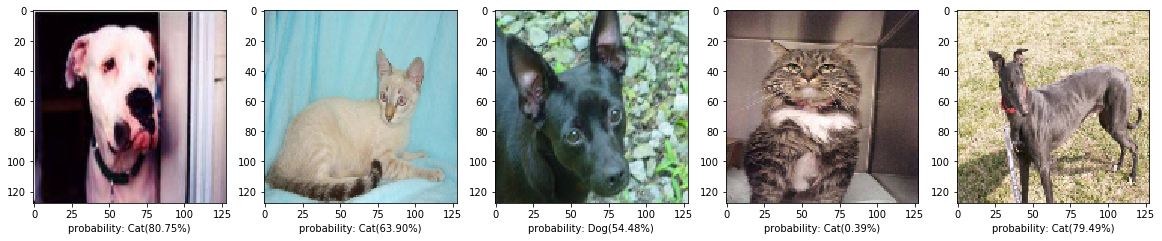

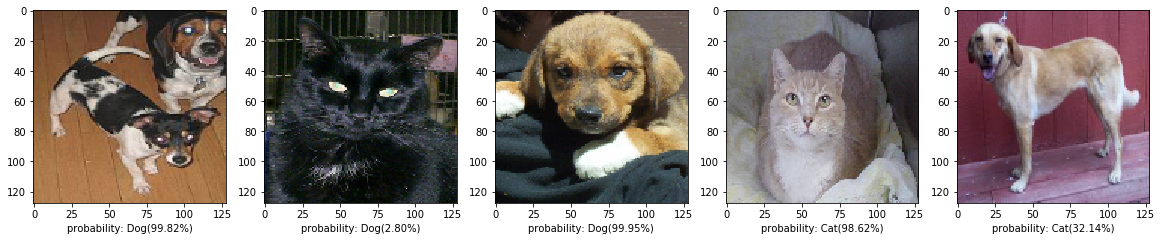

In [69]:
#随机预测2张图显示出来
visualize_predict(clf, test_reader)
visualize_predict(clf, test_reader)

In [6]:
import tarfile
a = tarfile.open('./images.tar')
print(a)
print(a.getmembers()[10].name)

Images/n02085620-Chihuahua/n02085620_11948.jpg


In [21]:
PET_CLASS = {
    'chihuahua': 0,

    'japanese_spaniel': 1,
    'japanese_chin': 1,


}
CLASSIFIER = re.compile('|'.join([re.escape(c) for c in PET_CLASS]))
print('|'.join([re.escape(c) for c in PET_CLASS]))

japanese_chin|japanese_spaniel|chihuahua


In [64]:
print(CLASSIFIER.search('xxxjapanese_spanielxxxchihuahua'))

<_sre.SRE_Match object; span=(3, 19), match='japanese_spaniel'>


In [55]:
print(PET_CLASS[CLASSIFIER.search('japanese_spaniel').group()])

1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D


model = Sequential()
model.add(Convolution2D(8, 3, 3, border_mode='same',
                        input_shape=[128,128,3]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit_generator(train_reader, 20000, 100, validation_data=vali_reader, nb_val_samples=32)

Epoch 1/100
20000/20000 [==============================] - 71s - loss: 0.6885 - acc: 0.5393 - val_loss: 0.6663 - val_acc: 0.7188